Find the markdown blocks that say interaction required! The notebook should take care of the rest!

# Import libs

In [1]:
import sys
import os
sys.path.append('..')
from eflow.foundation import DataPipeline,DataFrameTypes
from eflow.model_analysis import OutlierAnalysis
from eflow.utils.modeling_utils import optimize_model_grid
from eflow.utils.eflow_utils import get_type_holder_from_pipeline, remove_unconnected_pipeline_segments
from eflow.utils.pandas_utils import data_types_table
from eflow.utils.sys_utils import get_all_directories_from_path
from eflow.utils.sys_utils import load_pickle_object

import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import SCORERS
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

import copy
import pickle
from IPython.display import clear_output

In [2]:
# # Additional add ons
# !pip install pandasgui
# !pip install pivottablejs
# clear_output()

In [3]:
%matplotlib notebook
%matplotlib inline

## Declare Project Variables

### Interaction required

In [4]:
dataset_path = "Datasets/titanic_train.csv"

# -----
dataset_name = "Titanic Data"
pipeline_name = "Titanic Pipeline"

# -----


# -----
notebook_mode = True

## Clean out segment space

In [5]:
remove_unconnected_pipeline_segments()

# Import dataset

In [6]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

,Rows,Columns
0,891,12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
PassengerId,int64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Name,object
Sex,object


# Loading and init df_features

In [8]:
# Option: 1
# df_features = get_type_holder_from_pipeline(pipeline_name)

In [9]:
# Option: 2
df_features = DataFrameTypes()
df_features.init_on_json_file(os.getcwd() + f"/eflow Data/{dataset_name}/df_features.json")

In [10]:
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

,Data Types
Features,
Embarked,string
Cabin,string
Sex,string
Survived,bool
Parch,integer
SibSp,integer
Age,float
Fare,float
Pclass,category


# Any extra processing before eflow DataPipeline

In [11]:
display({val[0] for val in set(df["Cabin"].dropna().values)})
df["Cabin"] = [val[0] if isinstance(val,str) else val for val in df["Cabin"]]
df["Cabin"]

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'}

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin, Length: 891, dtype: object

# Setup pipeline structure

### Interaction Required

In [12]:
main_pipe = DataPipeline(pipeline_name,
                         df,
                         df_features)

The file 'root_pipeline.json' exist!
Now configuring object with proper pipeline segments...
Removing the feature: "Ticket"
Removing the feature: "PassengerId"
Removing the feature: "Name"


In [13]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C,C


In [14]:
main_pipe.perform_pipeline(df,
                           df_features)

Ignore feature:  Parch


In [15]:
df

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,0,22.0,1,0,7.2500,False,True,False,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False,True,False,False
2,1,26.0,0,0,7.9250,True,False,False,False,True,False,False,True
3,1,35.0,1,0,53.1000,True,False,True,False,False,False,False,True
4,0,35.0,0,0,8.0500,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,False,True,False,True,False,False,False,True
887,1,19.0,0,0,30.0000,True,False,True,False,False,False,False,True
888,0,28.0,1,2,23.4500,True,False,False,False,True,False,False,True
889,1,26.0,0,0,30.0000,False,True,True,False,False,True,False,False


# Seperate out data into train and test sets

In [16]:
X = df.drop(columns=df_features.target_feature()).values
y = df[df_features.target_feature()].values

In [17]:
feature_order = list(df.columns)

In [18]:
# del df

In [19]:
clf = IsolationForest(n_estimators=20, warm_start=True).fit(X)

In [20]:
cov = EllipticEnvelope(random_state=0,assume_centered=True).fit(X)

/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


In [21]:
one_svm = OneClassSVM(gamma='auto').fit(X)

In [22]:
model_list = [one_svm,clf,cov]
model=model_list[1]

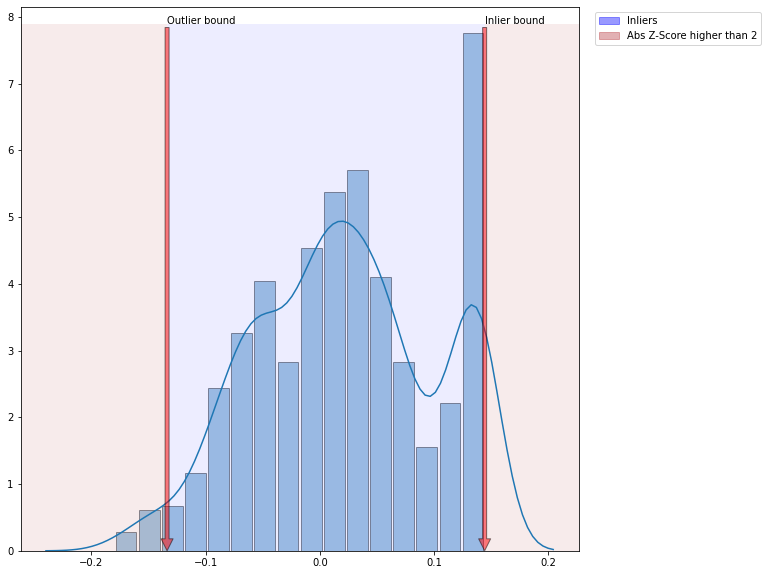

In [23]:
from eflow.utils.pandas_utils import zcore_remove_outliers
import seaborn as sns
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import copy

model_decisions=model.decision_function(X)

# model_decisions = np.delete(model_decisions,indexes[:int(len(indexes) * .7)])

zscore_val = 2
bool_series = pd.Series((model_decisions - model_decisions.mean()) / model_decisions.std(ddof=0)).between(zscore_val * -1,zscore_val)
hv_outlier_index_list = bool_series[bool_series==False].index.tolist()


zscore_val = 2
bool_series = pd.Series((model_decisions[bool_series] - model_decisions[bool_series].mean()) / model_decisions[bool_series].std(ddof=0)).between(zscore_val * -1,zscore_val)
md_outlier_index_list = bool_series[bool_series==False].index.tolist()

del bool_series

outlier_val = min(np.delete(model_decisions,md_outlier_index_list + hv_outlier_index_list))
inlier_val = max(np.delete(model_decisions,md_outlier_index_list + hv_outlier_index_list))

plt.figure(figsize=(10,10))
ax = sns.distplot(model_decisions,kde=True,hist_kws={'edgecolor':'black',"rwidth":.9,},bins=16)

ymax = ax.get_ylim()[1]-(ax.get_ylim()[1]*.03)

ann_1 = ax.annotate('Outlier bound', xy=(outlier_val, 0), xytext=(outlier_val, ymax),
                    arrowprops=dict(facecolor='red',alpha=.5))
ann_2 = ax.annotate('Inlier bound', xy=(inlier_val, 0), xytext=(inlier_val, ymax),
                    arrowprops=dict(facecolor='red',alpha=.5))

xmin = outlier_val
xmax = inlier_val

rect = patches.Rectangle((outlier_val,0),inlier_val-outlier_val,ymax-0, facecolor='blue', alpha=0.07, )
ax.add_patch(rect)

rect = patches.Rectangle((ax.get_xlim()[0],0),outlier_val-ax.get_xlim()[0],ymax-0, facecolor='#b93c43', alpha=0.1)
ax.add_patch(rect)

rect = patches.Rectangle((ax.get_xlim()[1],0),inlier_val-ax.get_xlim()[1],ymax-0, facecolor='#b93c43', alpha=0.1)
ax.add_patch(rect)

plt.legend(['Inliers', f'Abs Z-Score higher than {zscore_val}'],
           bbox_to_anchor=(1.02, 1),loc='upper left')
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('#b93c43')

for lh in leg.legendHandles:
    lh.set_alpha(.4)

plt.show()
plt.close("all")

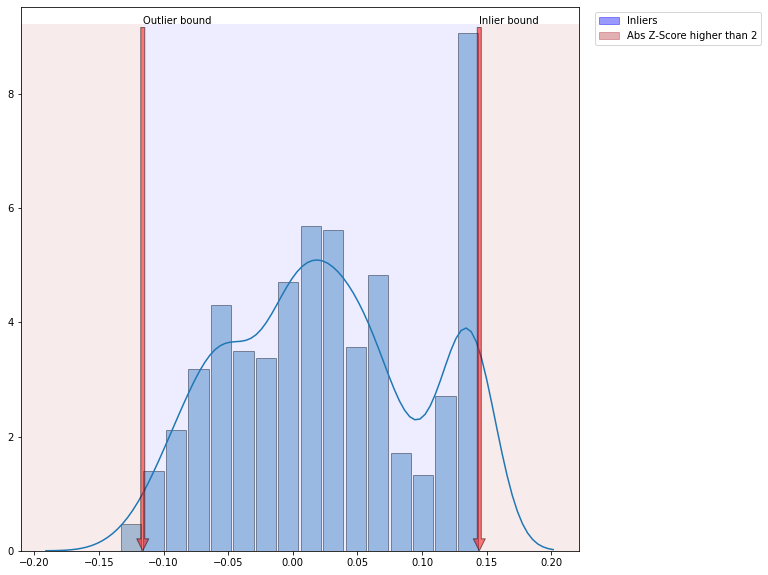

In [24]:
zscore_val = 2
tmp = np.delete(model_decisions, hv_outlier_index_list)
bool_series = pd.Series((tmp - tmp.mean()) / tmp.std(ddof=0)).between(zscore_val * -1,zscore_val)

outlier_val = min(tmp[bool_series])
inlier_val = max(tmp[bool_series])

del bool_series
del tmp

plt.figure(figsize=(10,10))
ax = sns.distplot(np.delete(model_decisions,hv_outlier_index_list),kde=True,hist_kws={'edgecolor':'black',"rwidth":.9,},bins=16)

ymax = ax.get_ylim()[1]-(ax.get_ylim()[1]*.03)

ax.annotate('Outlier bound', xy=(outlier_val, 0), xytext=(outlier_val, ymax),
            arrowprops=dict(facecolor='red',alpha=.5))
ax.annotate('Inlier bound', xy=(inlier_val, 0), xytext=(inlier_val, ymax),
            arrowprops=dict(facecolor='red',alpha=.5))

xmin = outlier_val
xmax = inlier_val

rect = patches.Rectangle((outlier_val,0),inlier_val-outlier_val,ymax-0, facecolor='blue', alpha=0.07, )
ax.add_patch(rect)

rect = patches.Rectangle((ax.get_xlim()[0],0),outlier_val-ax.get_xlim()[0],ymax-0, facecolor='#b93c43', alpha=0.1)
ax.add_patch(rect)

rect = patches.Rectangle((ax.get_xlim()[1],0),inlier_val-ax.get_xlim()[1],ymax-0, facecolor='#b93c43', alpha=0.1)
ax.add_patch(rect)

plt.legend(['Inliers', f'Abs Z-Score higher than {zscore_val}'],
           bbox_to_anchor=(1.02, 1),loc='upper left')
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('#b93c43')

for lh in leg.legendHandles:
    lh.set_alpha(.4)

plt.show()
plt.close("all")

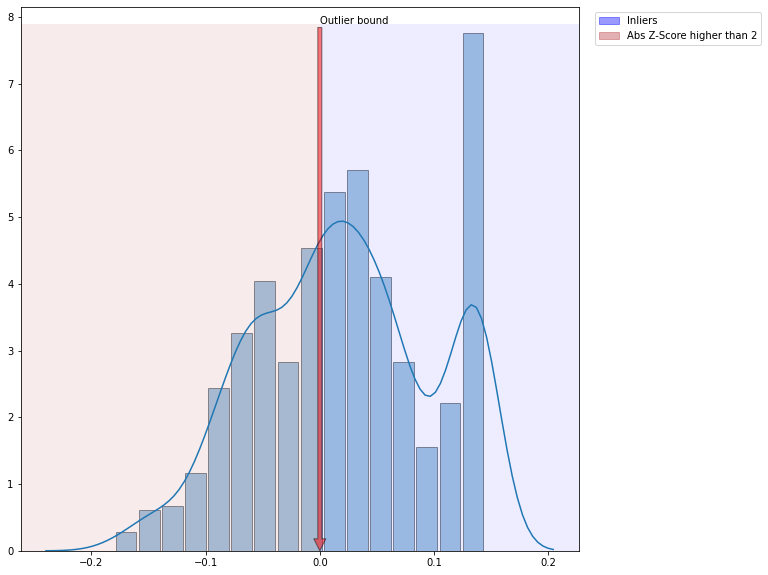

In [25]:
plt.figure(figsize=(10,10))
outlier_val = 0
inlier_val = max(model_decisions)
ax = sns.distplot(model_decisions,kde=True,hist_kws={'edgecolor':'black',"rwidth":.9,},bins=16)

ymax = ax.get_ylim()[1]-(ax.get_ylim()[1]*.03)

ax.annotate('Outlier bound', xy=(outlier_val, 0), xytext=(outlier_val, ymax),
            arrowprops=dict(facecolor='red',alpha=.5))

xmin = outlier_val
xmax = inlier_val

rect = patches.Rectangle((outlier_val,0),ax.get_xlim()[1],ymax-0, facecolor='blue', alpha=0.07, )
ax.add_patch(rect)

rect = patches.Rectangle((ax.get_xlim()[0],0),outlier_val-ax.get_xlim()[0],ymax-0, facecolor='#b93c43', alpha=0.1)
ax.add_patch(rect)

plt.legend(['Inliers', f'Abs Z-Score higher than {zscore_val}'],
           bbox_to_anchor=(1.02, 1),loc='upper left')
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('#b93c43')

for lh in leg.legendHandles:
    lh.set_alpha(.4)

plt.show()
plt.close("all")

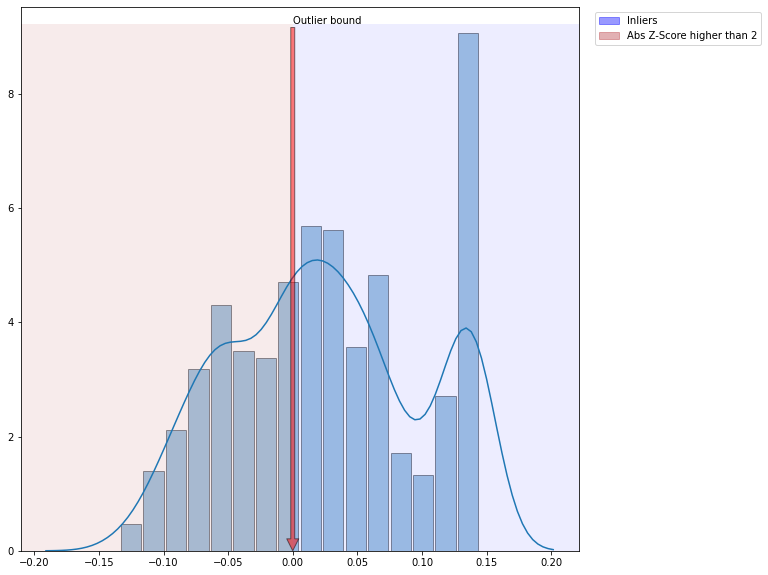

891


In [26]:
from eflow.utils.math_utils import auto_binning
from eflow.utils.pandas_utils import df_auto_binning


plt.figure(figsize=(10,10))
outlier_val = 0
inlier_val = max(np.delete(model_decisions,hv_outlier_index_list))
ax = sns.distplot(np.delete(model_decisions,hv_outlier_index_list),kde=True,hist_kws={'edgecolor':'black',"rwidth":.9,},bins=16)

ymax = ax.get_ylim()[1]-(ax.get_ylim()[1]*.03)

ax.annotate('Outlier bound', xy=(outlier_val, 0), xytext=(outlier_val, ymax),
            arrowprops=dict(facecolor='red',alpha=.5))

xmin = outlier_val
xmax = inlier_val

rect = patches.Rectangle((outlier_val,0),ax.get_xlim()[1],ymax-0, facecolor='blue', alpha=0.07, )
ax.add_patch(rect)

rect = patches.Rectangle((ax.get_xlim()[0],0),outlier_val-ax.get_xlim()[0],ymax-0, facecolor='#b93c43', alpha=0.1)
ax.add_patch(rect)

plt.legend(['Inliers', f'Abs Z-Score higher than {zscore_val}'],
           bbox_to_anchor=(1.02, 1),loc='upper left')
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('#b93c43')

for lh in leg.legendHandles:
    lh.set_alpha(.4)

plt.show()
plt.close("all")

model_decisions_tmp = copy.deepcopy(model_decisions)

model_decisions_tmp = model_decisions_tmp[~np.isnan(model_decisions_tmp)]

model_decisions_tmp = pd.to_numeric(model_decisions_tmp,
                                    errors='coerce')

tmp = pd.DataFrame(model_decisions_tmp,columns=["test"])

bins, labels = df_auto_binning(tmp,
                               DataFrameTypes(tmp),
                               "test",
                               bins=16)

model_decisions_tmp = pd.cut(model_decisions_tmp,
                             bins=bins,
                             labels=labels)
model_decisions_tmp = pd.Series(model_decisions_tmp)
print(len(model_decisions_tmp))


arr = model_decisions[~np.isnan(model_decisions)]
vals = model_decisions_tmp.value_counts().values


In [27]:
indexes = np.argwhere((model_decisions > .122) == True).reshape(-1).tolist()

In [28]:
len(indexes)

143

In [29]:
model_decisions_tmp.value_counts()

0.0228+ ⟷ 0.043       102
0.00253+ ⟷ 0.0228      97
0.124+ ⟷ 0.144         86
-0.0177+ ⟷ 0.00253     82
0.043+ ⟷ 0.0633        75
-0.0583+ ⟷ -0.038      73
-0.0785+ ⟷ -0.0583     59
0.0633+ ⟷ 0.0836       51
-0.038+ ⟷ -0.0177      51
-0.0988+ ⟷ -0.0785     44
0.104+ ⟷ 0.124         40
0.0836+ ⟷ 0.104        28
-0.119+ ⟷ -0.0988      21
-0.139+ ⟷ -0.119       12
-0.16+ ⟷ -0.139        12
-0.18+ ⟷ -0.16          4
dtype: int64

In [30]:
# from scipy.stats import norm

# for i,_ in enumerate(indexes):
    
#     model_decisions=model.decision_function(X)

#     model_decisions = np.delete(model_decisions,indexes[:i])

#     zscore_val = 2
#     bool_series = pd.Series((model_decisions - model_decisions.mean()) / model_decisions.std(ddof=0)).between(zscore_val * -1,zscore_val)
#     hv_outlier_index_list = bool_series[bool_series==False].index.tolist()


#     zscore_val = 2
#     bool_series = pd.Series((model_decisions[bool_series] - model_decisions[bool_series].mean()) / model_decisions[bool_series].std(ddof=0)).between(zscore_val * -1,zscore_val)
#     md_outlier_index_list = bool_series[bool_series==False].index.tolist()

#     del bool_series

#     outlier_val = min(np.delete(model_decisions,md_outlier_index_list + hv_outlier_index_list))
#     inlier_val = max(np.delete(model_decisions,md_outlier_index_list + hv_outlier_index_list))
    
#     plt.figure(figsize=(10,10))
#     outlier_val = 0
#     inlier_val = max(np.delete(model_decisions,hv_outlier_index_list))
#     ax = sns.distplot(np.delete(model_decisions,hv_outlier_index_list),kde=True,hist_kws={'edgecolor':'black',"rwidth":.9,},bins=16)

#     ymax = ax.get_ylim()[1]-(ax.get_ylim()[1]*.03)

#     ax.annotate('Outlier bound', xy=(outlier_val, 0), xytext=(outlier_val, ymax),
#                 arrowprops=dict(facecolor='red',alpha=.5))

#     xmin = outlier_val
#     xmax = inlier_val

#     rect = patches.Rectangle((outlier_val,0),ax.get_xlim()[1],ymax-0, facecolor='blue', alpha=0.07, )
#     ax.add_patch(rect)

#     rect = patches.Rectangle((ax.get_xlim()[0],0),outlier_val-ax.get_xlim()[0],ymax-0, facecolor='#b93c43', alpha=0.1)
#     ax.add_patch(rect)

#     plt.legend(['Inliers', f'Abs Z-Score higher than {zscore_val}'],
#                bbox_to_anchor=(1.02, 1),loc='upper left')
#     leg = ax.get_legend()
#     leg.legendHandles[0].set_color('blue')
#     leg.legendHandles[1].set_color('#b93c43')

#     for lh in leg.legendHandles:
#         lh.set_alpha(.4)

#     if i % 10 == 0:
#         plt.show()
    
#     mu, std = norm.fit(np.delete(model_decisions,hv_outlier_index_list))
#     print(f"mu={mu} std={std}")
    
#     plt.close("all")
    

In [31]:
outlier_analysis = OutlierAnalysis(dataset_name,
                                   model=clf,
                                   model_name="Isolation Forest",
                                   feature_order=feature_order,
                                   df_features=df_features,
                                   project_sub_dir="Outlier Analysis",
                                   overwrite_full_path=None,
                                   save_models=True,
                                   notebook_mode=True)

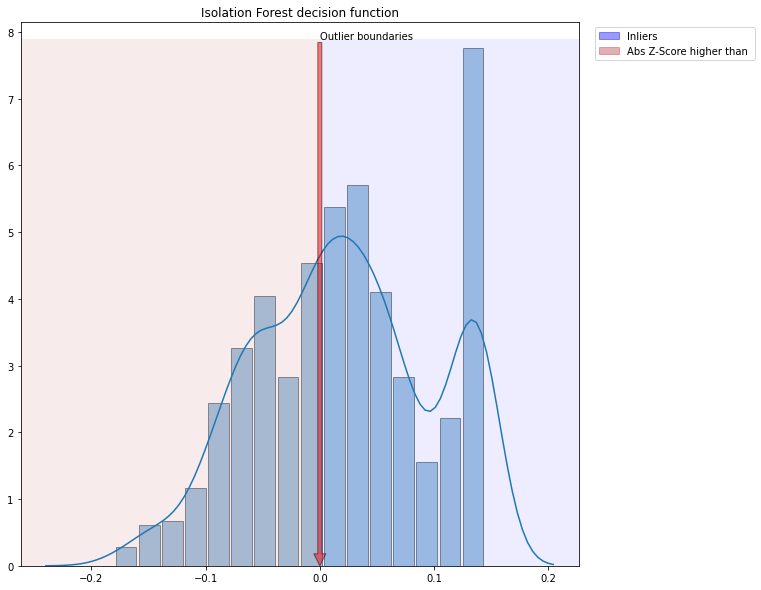

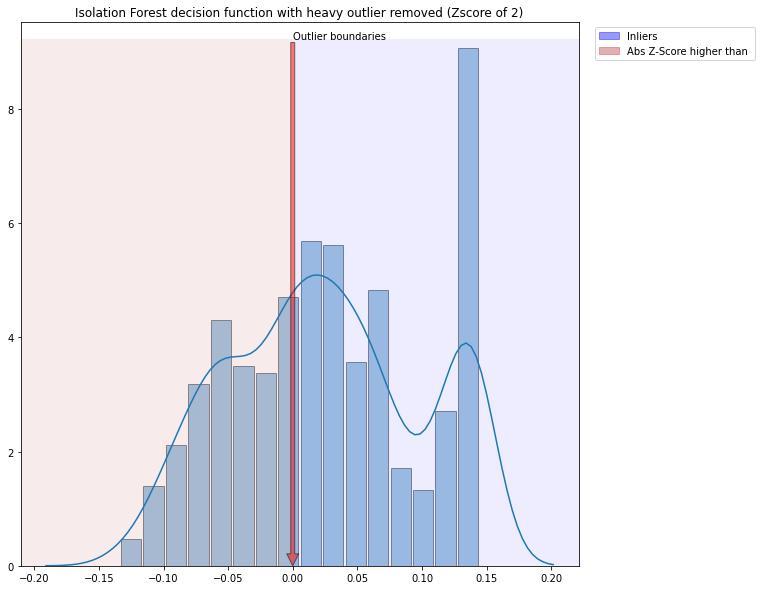

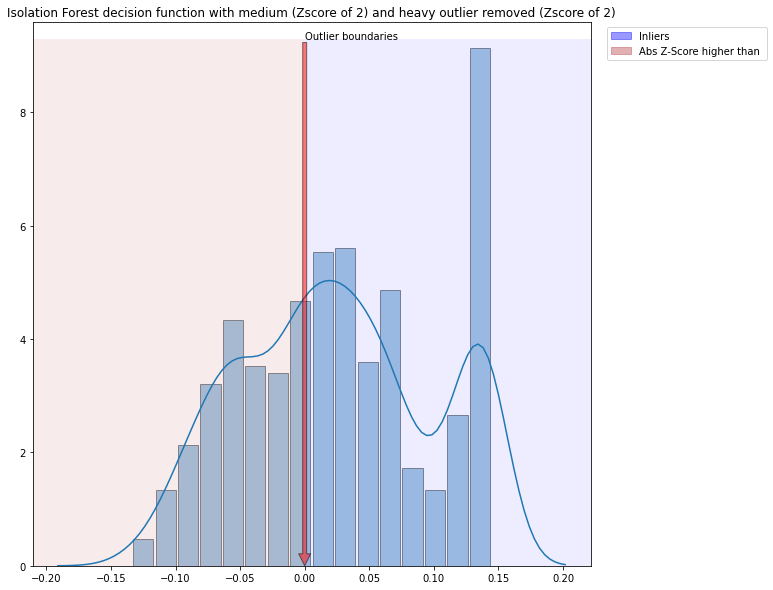

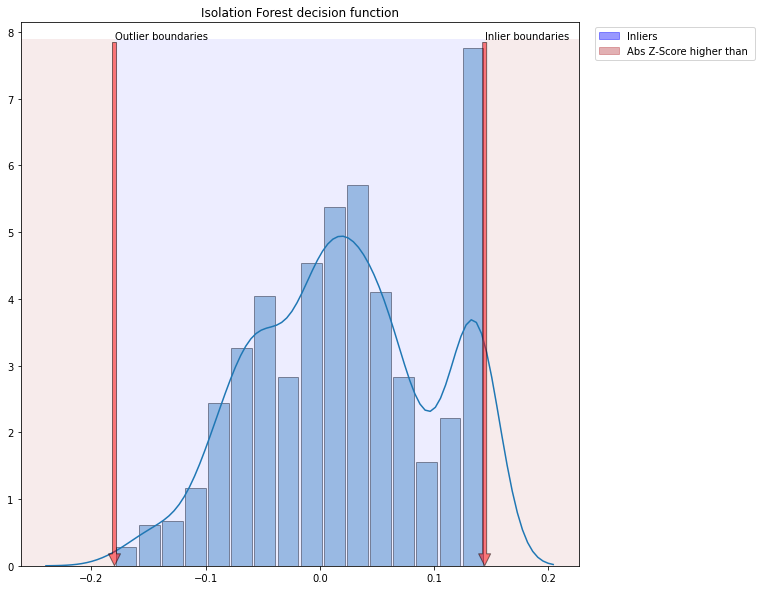

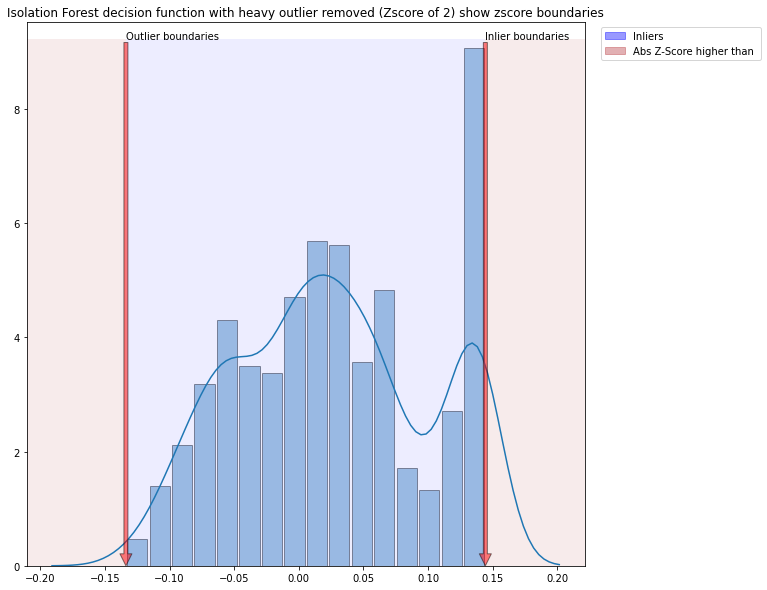

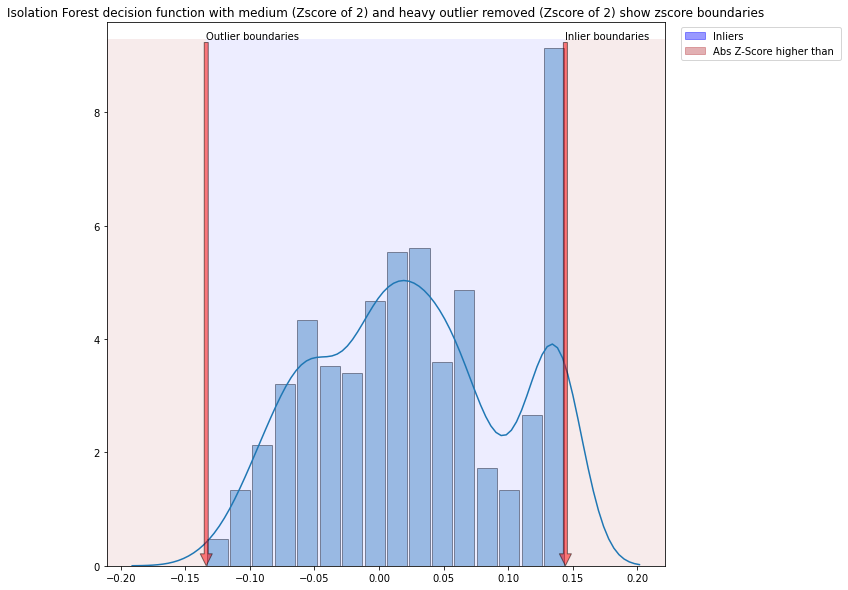

In [32]:
outlier_analysis.graph_decision_outliers(X,
                                         heavy_outlier_zscore=2,
                                         medium_outlier_zscore=2)

In [33]:
1/0

ZeroDivisionError: division by zero

In [ ]:
df.loc[md_outlier_index_list]

In [ ]:
n = 30
b = [1-(i*.02 + .1) if i <= 20 else .5 for i in range(0,n)]

In [ ]:
result = 1
for i in b:
    result *= i

In [ ]:
result * 100

In [ ]:
len(b)

In [ ]:
b

In [ ]:
import random

light_af_tokens = []

for i_c in range(1,10000):
    weapon_tokens = 8000
    armor_weapon_tokens = 1000
    weapons_dict = {"Primary":1060, "Secondary":1060, "Heavy":1060}
    armor_dict = {"Head": 1060, "Arms": 1060, "Chest": 1060, "Boots":1060, "Class":1060}
    
    engrams_count = int((weapon_tokens + armor_weapon_tokens)/20)
    avg_light = 1060
    
    random_num = 0
    
    for i in range(0,engrams_count):
        
        armor_avg = sum(armor_dict.values())/len(armor_dict.values())
        weapon_avg = sum(weapons_dict.values())/len(weapons_dict.values())
        
        if weapon_avg - avg_light < armor_avg - avg_light:
            random_num = 1
        else:
            random_num = 0
        
        if (1 == random_num and weapon_tokens >= 100) or armor_weapon_tokens == 0:
            weapon_type = random.choice(list(weapons_dict.keys()))
            weapons_dict[weapon_type] = avg_light + random.randint(1, 2)
            weapon_tokens -= 100
        
        else:
            if armor_weapon_tokens >= 20:
                random_num = random.randint(0, 1)

                if 1 == random_num:
                    weapon_type = random.choice(list(weapons_dict.keys()))
                    weapons_dict[weapon_type] = avg_light + random.randint(1, 2)
                else:
                    armor_type = random.choice(list(armor_dict.keys()))
                    armor_dict[armor_type] = avg_light + random.randint(1, 2)

                armor_weapon_tokens -= 20
            
            else:
                print("error")
                print(armor_weapon_tokens)
                print()
                
        avg_light = int((sum(weapons_dict.values()) + sum(armor_dict.values()))/(len(weapons_dict.values()) + len(armor_dict.values())))
        
    light_af_tokens.append(avg_light)

print(f"Engrams: {engrams_count}\nMax Light: {max(light_af_tokens)}\nMin Light: {min(light_af_tokens)}")
print(f"Avg: {sum(light_af_tokens)/len(light_af_tokens)}")